# 01 Face Generation

![](https://images.unsplash.com/photo-1499824643098-62967ac87503?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1047&q=80)

Picture by [Kevin Bluer](https://unsplash.com/photos/e6XqFP4kCxM)

In this exercise, you will basically redo what was done in the lectures, with faces. We will use the olivetti faces dataset.

So the first thing to is to load the dataset, using `fet_olivetti_faces` of scikit-learn.

In [1]:
### TODO: load the dataset
### STRIP_START ### 
# Import the dataset
from sklearn.datasets import fetch_olivetti_faces

X_train = fetch_olivetti_faces().data
target = fetch_olivetti_faces().target
### STRIP_END ###

You already know it, but feel free to display some faces, and get familiar with the dimensions.

(400, 4096)


[]

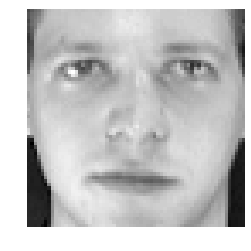

In [3]:
### TODO: Display some images and get the shapes
### STRIP_START ### 
import matplotlib.pyplot as plt

print(X_train.shape)

plt.imshow(X_train[0].reshape(64, 64), cmap = plt.cm.gray)
plt.axis('off')
plt.plot()
### STRIP_END ###

We will now create a CVAE, that will allow us to generate new faces.

Reminder, a CVAE architecture looks like this:
![](../../../00-Lectures/images/CVAE1.png)

Except that here it won't be digits, but faces of people.

Define the CVAE model now.

In [4]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [5]:
### TODO: Build the CVAE model
### STRIP_START ### 
from tensorflow.keras.layers import Input, Dense, Lambda, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Redefine the intermediate and latent dimensions
intermediate_dim = 512
latent_dim = 2
n_pixels = 4096
n_classes = 40

# Define the encoder part
x = Input(shape=(n_pixels,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# Define z
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Here is the only difference: merge latent space with labels
label = Input(shape=(n_classes,))
zc = Concatenate(axis=1)([z, label])

# Define the decoder part
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(n_pixels, activation='sigmoid')
h_decoded = decoder_h(zc)
x_decoded_mean = decoder_mean(h_decoded)

# end-to-end autoencoder
cvae = Model([x, label], x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model([x, label], z_mean)

# decoder
decoder_input = Input(shape=(latent_dim+n_classes,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

### STRIP_END ###

Instructions for updating:
Colocations handled automatically by placer.


Once you have built your model, compile it and train it on the data!

But first, do not forget: **use the custom KL loss** defined in the lectures.

In [6]:
### TODO: Compile and train your model
### STRIP_START ### 
from tensorflow.keras.losses import mean_squared_error, binary_crossentropy
from tensorflow.keras.backend import exp, square, mean, log
from tensorflow.keras.utils import to_categorical

def vae_loss(x, x_decoded_mean):
    classic_loss = binary_crossentropy(x, x_decoded_mean)*n_pixels
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = -0.5*K.sum(kl_loss, axis=-1)
    vae_loss = K.mean(classic_loss + kl_loss)    
    return vae_loss

batch_size = 16

y_train = to_categorical(target)

cvae.compile(optimizer='adam', loss=vae_loss)

cvae.fit([X_train, y_train], X_train, epochs=100,
         batch_size=batch_size)
### STRIP_END ###

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
400/400 [==============================] - 2s 4ms/sample - loss: 2779.9489
Epoch 2/100
400/400 [==============================] - 1s 3ms/sample - loss: 2724.6395
Epoch 3/100
400/400 [==============================] - 1s 3ms/sample - loss: 2709.3164
Epoch 4/100
400/400 [==============================] - 1s 3ms/sample - loss: 2689.6433
Epoch 5/100
400/400 [==============================] - 1s 3ms/sample - loss: 2676.2932
Epoch 6/100
400/400 [==============================] - 1s 3ms/sample - loss: 2665.4772
Epoch 7/100
400/400 [==============================] - 1s 3ms/sample - loss: 2657.3283
Epoch 8/100
400/400 [==============================] - 1s 3ms/sample - loss: 2650.7858
Epoch 9/100
400/400 [==============================] - 1s 3ms/sample - loss: 2645.4984
Epoch 10/100
400/400 [==============================] - 1s 3ms/sample - loss: 2641.5726
Epoch 11/100
400/400 [==============================] - 1s 3ms/sample - loss: 263

400/400 [==============================] - 1s 3ms/sample - loss: 2600.4910
Epoch 92/100
400/400 [==============================] - 1s 3ms/sample - loss: 2600.0730
Epoch 93/100
400/400 [==============================] - 1s 3ms/sample - loss: 2599.1050
Epoch 94/100
400/400 [==============================] - 1s 3ms/sample - loss: 2599.4059
Epoch 95/100
400/400 [==============================] - 1s 3ms/sample - loss: 2599.4656
Epoch 96/100
400/400 [==============================] - 1s 3ms/sample - loss: 2599.4943
Epoch 97/100
400/400 [==============================] - 1s 3ms/sample - loss: 2598.8037
Epoch 98/100
400/400 [==============================] - 1s 3ms/sample - loss: 2598.8435
Epoch 99/100
400/400 [==============================] - 1s 3ms/sample - loss: 2598.8074
Epoch 100/100
400/400 [==============================] - 1s 3ms/sample - loss: 2598.8304


In [11]:
cvae.fit([X_train, y_train], X_train, epochs=20, batch_size=32)

Epoch 1/20
400/400 [==============================] - 1s 2ms/sample - loss: 2597.8566
Epoch 2/20
400/400 [==============================] - 1s 2ms/sample - loss: 2597.0460
Epoch 3/20
400/400 [==============================] - 1s 2ms/sample - loss: 2596.7991
Epoch 4/20
400/400 [==============================] - 1s 2ms/sample - loss: 2596.7824
Epoch 5/20
400/400 [==============================] - 1s 2ms/sample - loss: 2596.7666
Epoch 6/20
400/400 [==============================] - 1s 2ms/sample - loss: 2596.9760
Epoch 7/20
400/400 [==============================] - 1s 2ms/sample - loss: 2596.6045
Epoch 8/20
400/400 [==============================] - 1s 2ms/sample - loss: 2596.2664
Epoch 9/20
400/400 [==============================] - 1s 2ms/sample - loss: 2596.8224
Epoch 10/20
400/400 [==============================] - 1s 2ms/sample - loss: 2597.4981
Epoch 11/20
400/400 [==============================] - 1s 2ms/sample - loss: 2596.6669
Epoch 12/20
400/400 [==============================]

Now, using the encoder part only, have a look at the latent space: display the values of the latent variables in a scatter plot.

In [16]:
# Convert it to categorical
val = to_categorical(5, num_classes=n_classes)

# Create the input vector (latent value and digit class)
input_vector = np.zeros((1, latent_dim + n_classes))
input_vector[0,latent_dim:] = val
input_vector

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

[]

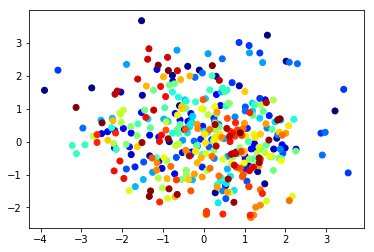

In [12]:
### TODO: Display the latent variables using the encoder side
### STRIP_START ### 
latent_variables = encoder.predict([X_train, y_train])

plt.scatter(latent_variables[:,0], latent_variables[:,1], c=target, cmap=plt.cm.jet)
plt.plot()
### STRIP_END ###

What is the range that the latent variables can take? (i.e. what are the minimum and maximum values?)

Use that range to generate new faces of a person now.

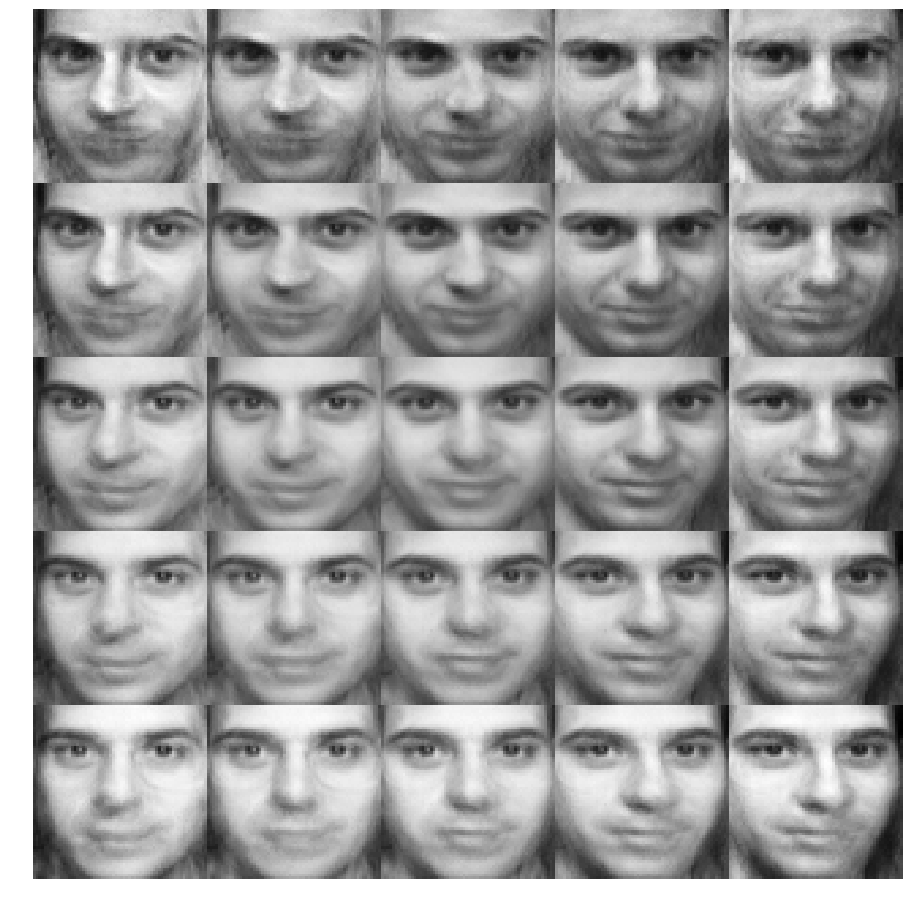

In [18]:
### TODO: Generate and display faces
### STRIP_START ### 
import numpy as np

# Choose a face to generate
face_to_generate = 8

# Convert it to categorical
val = to_categorical(face_to_generate, num_classes=n_classes)

# display a 2D manifold of the faces
n = 5 
image_size = 64

figure = np.zeros((image_size * n, image_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        # Create the input vector (latent value and face class)
        input_vector = np.zeros((1, latent_dim + n_classes))
        input_vector[0,latent_dim:] = val
        input_vector[0, 0]=xi
        input_vector[0, 1]=yi
        
        generated_x = generator.predict(input_vector)
        face = generated_x[0].reshape(image_size, image_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = face

plt.figure(figsize=(16, 16))
plt.imshow(figure, cmap = plt.cm.gray)
plt.axis('off')
plt.show()


### STRIP_END ###

How do you interpret the latent variables in that case?